In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
airline = \
pd.read_csv("./data/airline_passengers.csv",
           index_col="Month", parse_dates=True)

In [3]:
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Simple Moving Average

In [4]:
airline["6M SMA"] = \
airline["Thousands of Passengers"].rolling(window=6).mean()
airline["12M SMA"] = \
airline["Thousands of Passengers"].rolling(window=12).mean()

In [5]:
airline.head(18)

,Thousands of Passengers,6M SMA,12M SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,124.500000,NaN
1949-07-01,148,130.500000,NaN
1949-08-01,148,135.500000,NaN
1949-09-01,136,136.166667,NaN


<AxesSubplot:xlabel='Month'>

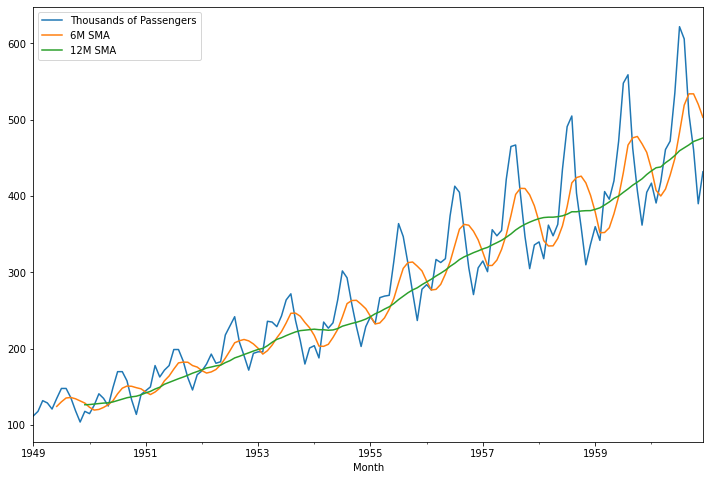

In [6]:
airline.plot(figsize=(12,8))

In [7]:
from sklearn.metrics import mean_squared_error

In [8]:
mean_squared_error(airline["Thousands of Passengers"]["1949-06-01":], airline["6M SMA"]["1949-06-01":])

2091.7370103916865

### Weighted Moving Average

In [9]:
airline["WMA12"] = \
airline["Thousands of Passengers"].ewm(span=12).mean()
airline["WMA6"] = \
airline["Thousands of Passengers"].ewm(span=6).mean()

<AxesSubplot:xlabel='Month'>

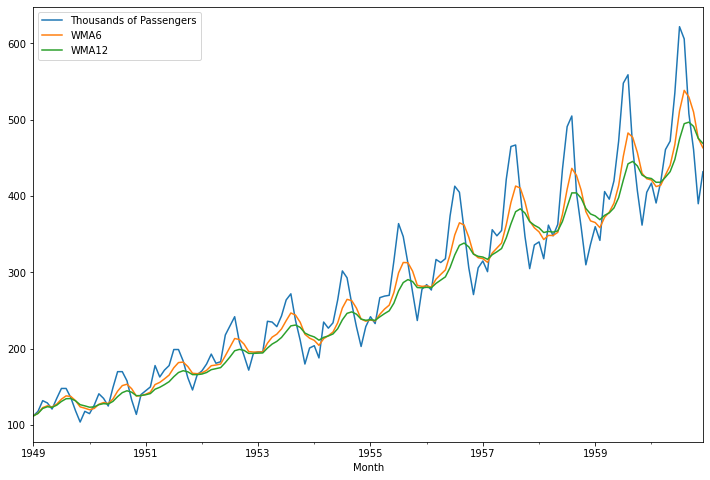

In [14]:
airline[["Thousands of Passengers", "WMA6", "WMA12"]].plot(figsize=(12,8))

### Simple Exponential Smoothing, Holt's, Holt-Winter's

In [16]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [17]:
train = airline[:"1959"]
test = airline["1960":]

<AxesSubplot:xlabel='Month'>

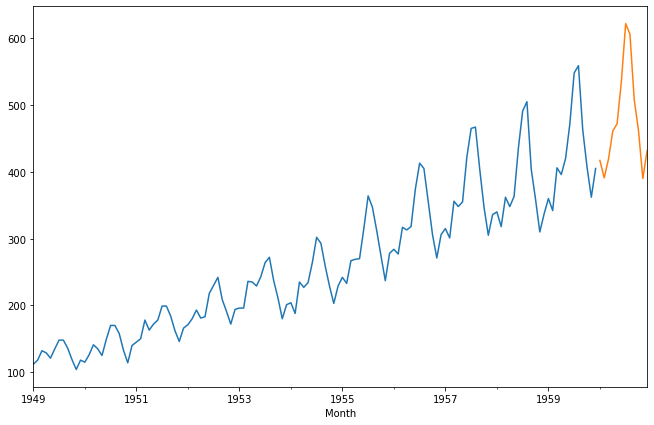

In [21]:
train["Thousands of Passengers"].plot(figsize=(11,7))
test["Thousands of Passengers"].plot()

In [22]:
ses_model = \
SimpleExpSmoothing(np.asarray(train["Thousands of Passengers"]))

In [24]:
ses_result = ses_model.fit()

In [25]:
y_hat = test.copy()

In [26]:
y_hat["SES"] = ses_result.forecast(len(test))

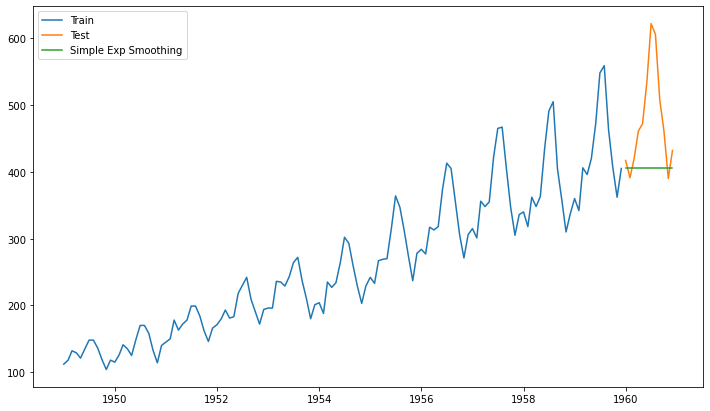

In [27]:
plt.figure(figsize=(12,7))
plt.plot(train["Thousands of Passengers"], label="Train")
plt.plot(test["Thousands of Passengers"], label="Test")
plt.plot(y_hat["SES"], label="Simple Exp Smoothing")
plt.legend()

In [29]:
rmse = np.sqrt(mean_squared_error(test["Thousands of Passengers"], y_hat["SES"]))

In [30]:
rmse

102.97653454387881

### Holt's

In [31]:
from statsmodels.tsa.api import Holt

In [32]:
holt_model = Holt(np.asarray(train["Thousands of Passengers"]))

In [33]:
holt_result = holt_model.fit()

In [34]:
y_hat["HOLT"] = holt_result.forecast(len(test))

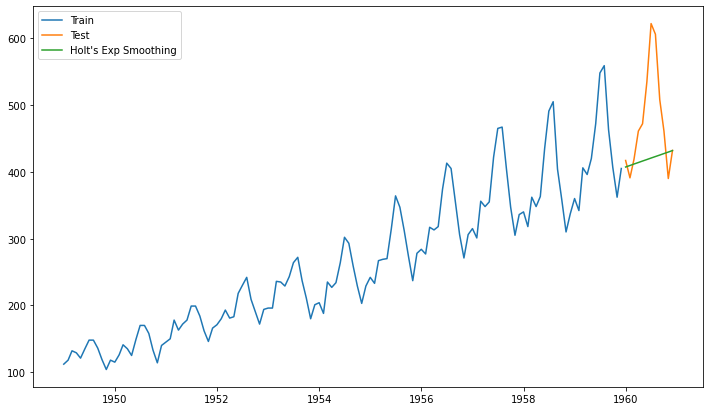

In [35]:
plt.figure(figsize=(12,7))
plt.plot(train["Thousands of Passengers"], label="Train")
plt.plot(test["Thousands of Passengers"], label="Test")
plt.plot(y_hat["HOLT"], label="Holt's Exp Smoothing")
plt.legend()

In [36]:
rmse = np.sqrt(mean_squared_error(test["Thousands of Passengers"], y_hat["HOLT"]))

In [37]:
rmse

92.66610484641392

### Holt-Winter's

In [38]:
from statsmodels.tsa.api import ExponentialSmoothing

In [41]:
winter_model = ExponentialSmoothing(
    np.asarray(train["Thousands of Passengers"]),
    seasonal_periods=12, trend="add", seasonal="add"    
)

In [42]:
winter_result = winter_model.fit()

C:\ProgramData\Anaconda3\envs\tsa\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [43]:
y_hat["WINTER"] = winter_result.forecast(len(test))

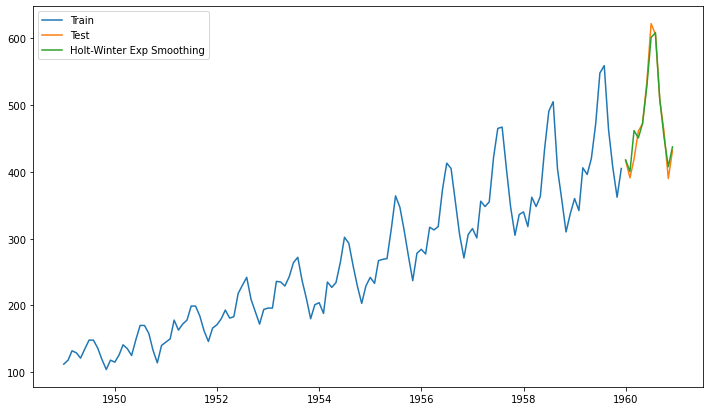

In [44]:
plt.figure(figsize=(12,7))
plt.plot(train["Thousands of Passengers"], label="Train")
plt.plot(test["Thousands of Passengers"], label="Test")
plt.plot(y_hat["WINTER"], label="Holt-Winter Exp Smoothing")
plt.legend()

In [45]:
rmse = np.sqrt(mean_squared_error(test["Thousands of Passengers"], y_hat["WINTER"]))

In [46]:
rmse

15.570830479207405

### ARIMA

In [47]:
import statsmodels.api as sm

In [50]:
arima = sm.tsa.statespace.SARIMAX(
    train["Thousands of Passengers"],
    order=(2,1,1),
    seasonal_order=(0,1,0,12),
    enforce_stationary=False,
    enforce_invertibility=False
)

C:\ProgramData\Anaconda3\envs\tsa\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\tsa\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [51]:
arima_result = arima.fit()

C:\ProgramData\Anaconda3\envs\tsa\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [52]:
y_hat["ARIMA"] = \
arima_result.predict(start="1960-01-01",
                    end="1960-12-01", dynamic=True)

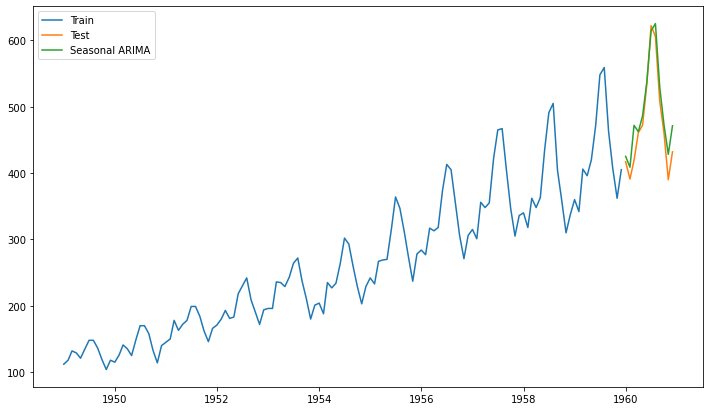

In [53]:
plt.figure(figsize=(12,7))
plt.plot(train["Thousands of Passengers"], label="Train")
plt.plot(test["Thousands of Passengers"], label="Test")
plt.plot(y_hat["ARIMA"], label="Seasonal ARIMA")
plt.legend()

In [54]:
rmse = np.sqrt(mean_squared_error(test["Thousands of Passengers"], y_hat["ARIMA"]))

In [55]:
rmse

24.87432090051914